In [3]:
from fastai2.vision.all import *
path = untar_data(URLs.PASCAL_2007)

/jet/var/python/lib/python3.6/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [30]:
%matplotlib inline

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/jet/.fastai/data/pascal_2007/train/004708.jpg'), ['cat', 'sofa'])

In [13]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), # ImageBlock - image with path to tensor
                   get_x = get_x, get_y = get_y)            # MultiCategoryBlock - label to one-hot-encoding tensor
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x336,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [15]:
dsets.train[1][1] # one-hot encoding (same length for all labels)

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])

In [17]:
idxs = torch.where(dsets.train[1][1]==1)[0]
dsets.train.vocab[idxs]

(#1) ['person']

In [25]:
print('number of labels:', len(dsets.train.vocab))
dsets.train.vocab[:5]

number of labels: 20


(#5) ['aeroplane','bicycle','bird','boat','bottle']

In [26]:
# Dataframe has is_valid column, so the images are splitted by this column on training and validation set,
# To explicitly choose the elements of our validation set, we need to write a function and pass it to splitter 
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [38]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))  # make images the same size
dls = dblock.dataloaders(df, bs=128) # bs=64 by default, 

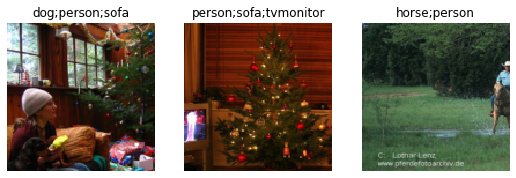

In [39]:
dls.show_batch(nrows=1, ncols=3)

In [40]:
# loss function -- Binary Cross-Entropy, fastai choose it by itself since one hot encoded labels are used
learn = cnn_learner(dls, resnet18)

In [41]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([128, 20])

In [42]:
activs[0] # 20 guesses for each image from batch size
# They aren’t yet scaled to between 0 and 1, but we learned how to do that

tensor([ 0.9557,  0.3727, -3.7156, -1.4190,  0.8080,  3.1050,  1.0919,  2.4638,
        -0.3952, -2.7860,  1.5746,  0.5250, -2.8783, -5.2579,  3.6304,  0.0178,
         1.0744,  3.8387, -1.9338,  0.9710], grad_fn=<SelectBackward>)

In [43]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [44]:
# Since we have a one-hot-encoded target, we will use BCEWithLogitsLoss:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0784, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be automatically chosen for us. fastai knows that the DataLoaders has multiple category labels, so it will use nn.BCEWithLogitsLoss by default.

In [45]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [46]:
# We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4) # We can pass freeze_epochs to tell fastai how many epochs to train #
                        #for while frozen. It will automatically change learning rates appropriately for most datasets.

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.972774,0.717068,0.226056,03:10
1,0.888999,0.656657,0.269641,03:10
2,0.789313,0.500927,0.324303,03:06
3,0.635954,0.211578,0.802470,03:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.231706,0.160074,0.899422,04:02
1,0.191901,0.126299,0.936633,04:00
2,0.163011,0.117767,0.948307,03:57


# Note
https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb
1) when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task. This newly added linear layer will have entirely random weights. Therefore, our model prior to fine-tuning has entirely random outputs. But that does not mean that it is an entirely random model! All of the layers prior to the last one have been carefully trained to be good at image classification tasks in general. As we saw in the images from the Zeiler and Fergus paper in https://arxiv.org/pdf/1311.2901.pdf
2) We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task, and only adjust them as required for the specifics of our particular task.
Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task (classifying pet breeds) without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called freezing those pretrained layers.

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. When we call the fine_tune method fastai does two things:

Trains the randomly added layers for one epoch, with all other layers frozen
Unfreezes all of the layers, and trains them all for the number of epochs requested

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called tensor cores that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add to_fp16() after your Learner creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision:


In [ ]:
# there is no NVIDIA GPU to use this part of code
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)